In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# Loading the Dataset

In [3]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [4]:
np.unique(y)

array([0, 1])

In [5]:
X.groupby(y).size()

target
0    212
1    357
dtype: int64

# Model Probability Discretization

When we want to build a model to rank, we would like to know if the mean of our target variables increases with the probability. In order to check that, it is common to discretise the model probabilities that is provided by `model.predict_proba(X)[:, 1]`. If the mean target increases monotonically with each bins boundaries, than we can rest assure that our model is doing some sort of ranking.

## With Decision Trees

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.50)

In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [31]:
y_prob = model.predict_proba(X_test)[:,1]
results_df = pd.DataFrame({'prob': y_prob,'target': y_test})
results_df.head()

,prob,target
355,0.999642,1
465,0.107700,1
152,0.999994,1
480,0.998275,1
414,0.165381,0


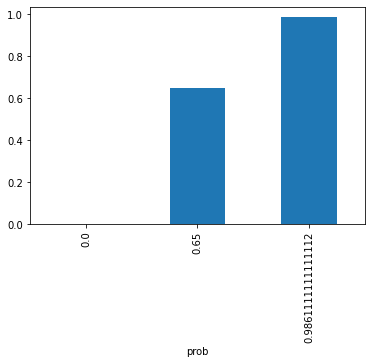

In [28]:
from feature_engine.discretisation import DecisionTreeDiscretiser

disc = DecisionTreeDiscretiser(cv=3, scoring='roc_auc', variables=['prob'], regression=False)

results_df_t = disc.fit_transform(results_df, y_test)

results_df_t.groupby('prob')['target'].mean().plot(kind='bar');

In [40]:
import string

tree_predictions = np.sort(results_df_t['prob'].unique())

ratings_map = {tree_prediction: rating for rating, tree_prediction in zip(string.ascii_uppercase, tree_predictions)}
ratings_map

{0.0: 'A', 0.65: 'B', 0.9861111111111112: 'C'}

In [41]:
results_df_t['rating'] = results_df_t['prob'].map(ratings_map)
results_df_t.head()

,prob,target,rating
506,0.986111,1,C
499,0.000000,0,A
67,0.986111,1,C
293,0.986111,1,C
198,0.000000,0,A


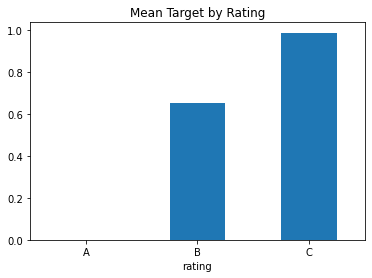

In [42]:
results_df_t.groupby('rating')['target'].mean().plot(kind='bar', rot=0, title="Mean Target by Rating");

In [43]:
results_df['rating'] = results_df_t['rating']
results_df.head()

,prob,target,rating
355,0.999642,1,NaN
465,0.107700,1,NaN
152,0.999994,1,NaN
480,0.998275,1,NaN
414,0.165381,0,NaN


In [19]:
results_df.groupby('rating').agg(lower_boundary = ('prob', 'min'), upper_boundary=('prob', 'max'))

,lower_boundary,upper_boundary
rating,,
A,1.651897e-37,0.131381
B,1.503666e-01,0.639979
C,6.457059e-01,0.776343
D,7.809473e-01,1.000000


## With Equal Width Discretiser

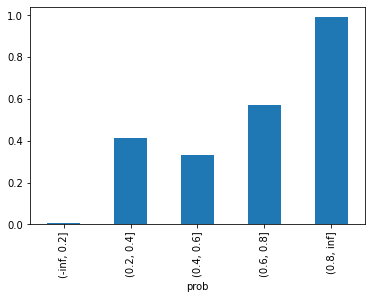

In [20]:
from feature_engine.discretisation import EqualWidthDiscretiser

disc = EqualWidthDiscretiser(bins=5, variables=['prob'], return_boundaries=True)
results_df_t = disc.fit_transform(results_df)
results_df_t.groupby('prob')['target'].mean().plot(kind='bar');

## With EqualFrequencyDiscretiser

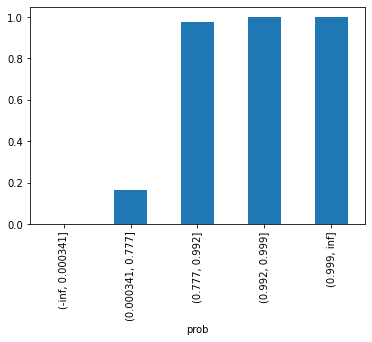

In [21]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

disc = EqualFrequencyDiscretiser(q=5, variables=['prob'], return_boundaries=True)
results_df_t = disc.fit_transform(results_df)
results_df_t.groupby('prob')['target'].mean().plot(kind='bar');